<a href="https://colab.research.google.com/github/Isanjalee/fyp/blob/ARIMA_LSTMs_PROPHET/ARIMA_LSTMs_PROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

dataset1 = pd.read_csv('/content/drive/MyDrive/FYP - DATASET/taxi+_zone_lookup.csv')
dataset2 = pd.read_csv('/content/drive/MyDrive/FYP - DATASET/11.csv')

dataset1.info()
dataset2.info()

# Sort dataset1 in ascending order based on LocationID
dataset1_sorted = dataset1.sort_values(by='LocationID')
dataset2_sorted = dataset2.sort_values(by='locationID')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    263 non-null    int64 
 1   Borough       263 non-null    object
 2   Zone          263 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   Dispatching_base_num  1048575 non-null  object
 1   Pickup_date           1048575 non-null  object
 2   Affiliated_base_num   1036592 non-null  object
 3   locationID            1048575 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 32.0+ MB


In [4]:
dataset1_sorted

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
258,259,Bronx,Woodlawn/Wakefield,Boro Zone
259,260,Queens,Woodside,Boro Zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone


In [5]:
dataset2_sorted

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
840334,B02682,2/12/2015 9:49,B02306,1
171314,B02682,5/17/2015 11:43,B02682,1
541777,B02682,3/31/2015 8:07,B02682,1
127618,B02764,2/7/2015 14:57,B02764,1
925168,B02682,6/18/2015 11:37,B02682,1
...,...,...,...,...
502480,B02617,5/21/2015 13:13,B02682,265
127910,B02682,5/17/2015 10:08,B02682,265
293873,B02764,4/15/2015 9:52,B00446,265
796497,B02764,1/6/2015 21:25,B02764,265


In [6]:
dataset2_filtered = dataset2_sorted[~dataset2_sorted['locationID'].isin([264, 265])]

In [7]:
merged_dataset = pd.merge(dataset2_filtered, dataset1_sorted, how='left', left_on='locationID', right_on='LocationID', suffixes=('_dataset2', '_dataset1'))


print(merged_dataset)

        Dispatching_base_num      Pickup_date Affiliated_base_num  locationID  \
0                     B02682   2/12/2015 9:49              B02306           1   
1                     B02682  5/17/2015 11:43              B02682           1   
2                     B02682   3/31/2015 8:07              B02682           1   
3                     B02764   2/7/2015 14:57              B02764           1   
4                     B02682  6/18/2015 11:37              B02682           1   
...                      ...              ...                 ...         ...   
1048106               B02764   2/8/2015 20:11              B02765         263   
1048107               B02764  5/21/2015 14:06              B02764         263   
1048108               B02598   1/20/2015 4:23              B02598         263   
1048109               B02764  2/23/2015 19:04              B02764         263   
1048110               B02598  1/20/2015 19:39              B02598         263   

         LocationID    Boro

In [8]:
missing_values = merged_dataset.isnull().sum()
print(missing_values)

Dispatching_base_num        0
Pickup_date                 0
Affiliated_base_num     11949
locationID                  0
LocationID                  0
Borough                     0
Zone                        0
service_zone                0
dtype: int64


In [9]:
merged_dataset = merged_dataset.dropna(subset=['Affiliated_base_num','LocationID','Borough','Zone','service_zone'])


print(merged_dataset)

missing_values = merged_dataset.isnull().sum()
print(missing_values)

        Dispatching_base_num      Pickup_date Affiliated_base_num  locationID  \
0                     B02682   2/12/2015 9:49              B02306           1   
1                     B02682  5/17/2015 11:43              B02682           1   
2                     B02682   3/31/2015 8:07              B02682           1   
3                     B02764   2/7/2015 14:57              B02764           1   
4                     B02682  6/18/2015 11:37              B02682           1   
...                      ...              ...                 ...         ...   
1048106               B02764   2/8/2015 20:11              B02765         263   
1048107               B02764  5/21/2015 14:06              B02764         263   
1048108               B02598   1/20/2015 4:23              B02598         263   
1048109               B02764  2/23/2015 19:04              B02764         263   
1048110               B02598  1/20/2015 19:39              B02598         263   

         LocationID    Boro

### Outlier Ditection

In [11]:
from scipy.stats import zscore


numeric_columns = ['locationID', 'LocationID']


z_scores = zscore(merged_dataset[numeric_columns])


outliers = (abs(z_scores) > 3)
merged_dataset_no_outliers = merged_dataset[~outliers.all(axis=1)]


print(merged_dataset_no_outliers)

       Dispatching_base_num   Pickup_date Affiliated_base_num  locationID  \
0                    B02682  10/18/ 12:17              B02682           1   
1                    B02764   09/9/ 15:14              B02764           1   
2                    B02682  10/18/ 11:37              B02682           1   
3                    B02682  12/10/ 16:15              B02764           1   
4                    B02682  09/28/ 08:07              B02682           1   
...                     ...           ...                 ...         ...   
995747               B02247  09/15/ 09:02              B02247         263   
995748               B02764  11/17/ 19:50              B02764         263   
995749               B02247  09/18/ 19:22              B02247         263   
995750               B02764  08/18/ 12:21              B02764         263   
995751               B02764   09/9/ 02:11              B02788         263   

        LocationID    Borough            Zone service_zone  
0             

In [12]:
merged_dataset_no_outliers

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,LocationID,Borough,Zone,service_zone
0,B02682,10/18/ 12:17,B02682,1,1.0,EWR,Newark Airport,EWR
1,B02764,09/9/ 15:14,B02764,1,1.0,EWR,Newark Airport,EWR
2,B02682,10/18/ 11:37,B02682,1,1.0,EWR,Newark Airport,EWR
3,B02682,12/10/ 16:15,B02764,1,1.0,EWR,Newark Airport,EWR
4,B02682,09/28/ 08:07,B02682,1,1.0,EWR,Newark Airport,EWR
...,...,...,...,...,...,...,...,...
995747,B02247,09/15/ 09:02,B02247,263,263.0,Manhattan,Yorkville West,Yellow Zone
995748,B02764,11/17/ 19:50,B02764,263,263.0,Manhattan,Yorkville West,Yellow Zone
995749,B02247,09/18/ 19:22,B02247,263,263.0,Manhattan,Yorkville West,Yellow Zone
995750,B02764,08/18/ 12:21,B02764,263,263.0,Manhattan,Yorkville West,Yellow Zone


### Identifying Boroughs

In [14]:
boroughs = merged_dataset_no_outliers['Borough'].unique()


borough_data = {}
for borough in boroughs:
    borough_data[borough] = merged_dataset_no_outliers[merged_dataset_no_outliers['Borough'] == borough]


for borough, data in borough_data.items():
    print(f'\nData for Borough: {borough}')
    print(data)


Data for Borough: EWR
   Dispatching_base_num      Pickup_date Affiliated_base_num  locationID  \
0                B02682   2/12/2015 9:49              B02306           1   
1                B02682  5/17/2015 11:43              B02682           1   
2                B02682   3/31/2015 8:07              B02682           1   
3                B02764   2/7/2015 14:57              B02764           1   
4                B02682  6/18/2015 11:37              B02682           1   
5                B02682   5/17/2015 8:15              B02682           1   
6                B02682  6/18/2015 12:17              B02682           1   
7                B02764  4/13/2015 16:17              B02764           1   
8                B02764   3/4/2015 15:14              B02764           1   
9                B02764  2/22/2015 13:00              B02764           1   
10               B02682  2/10/2015 16:15              B02764           1   

    LocationID Borough            Zone service_zone  
0         

### Normalize Data

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'numeric_columns' are the columns you want to normalize
numeric_columns = ['locationID', 'LocationID']  # Add other numeric columns as needed

# Initialize Min-Max scaler
scaler = MinMaxScaler()

# Normalize the numeric columns for each borough
for borough, data in borough_data.items():
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Display the normalized DataFrame for each borough
print(f'\nNormalized Data for Borough: {borough}')
print(data)


Normalized Data for Borough: Brooklyn
        Dispatching_base_num      Pickup_date Affiliated_base_num  locationID  \
14273                 B02764  3/22/2015 14:43              B02764         0.0   
14274                 B02598  1/23/2015 22:55              B02598         0.0   
14275                 B02682   6/18/2015 8:00              B02682         0.0   
14276                 B02682  6/17/2015 11:01              B02682         0.0   
14277                 B02764   4/10/2015 1:25              B02764         0.0   
...                      ...              ...                 ...         ...   
1022227               B02764    1/1/2015 1:00              B02764         1.0   
1022228               B02682  6/17/2015 14:10              B02682         1.0   
1022229               B02617  5/19/2015 10:10              B02617         1.0   
1022230               B02617  5/24/2015 18:18              B02765         1.0   
1022231               B02764   4/5/2015 12:17              B02764     

<ipython-input-15-a83a319da8c1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
<ipython-input-15-a83a319da8c1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
<ipython-input-15-a83a319da8c1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [16]:
data

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,LocationID,Borough,Zone,service_zone
14273,B02764,3/22/2015 14:43,B02764,0.0,0.0,Brooklyn,Bath Beach,Boro Zone
14274,B02598,1/23/2015 22:55,B02598,0.0,0.0,Brooklyn,Bath Beach,Boro Zone
14275,B02682,6/18/2015 8:00,B02682,0.0,0.0,Brooklyn,Bath Beach,Boro Zone
14276,B02682,6/17/2015 11:01,B02682,0.0,0.0,Brooklyn,Bath Beach,Boro Zone
14277,B02764,4/10/2015 1:25,B02764,0.0,0.0,Brooklyn,Bath Beach,Boro Zone
...,...,...,...,...,...,...,...,...
1022227,B02764,1/1/2015 1:00,B02764,1.0,1.0,Brooklyn,Windsor Terrace,Boro Zone
1022228,B02682,6/17/2015 14:10,B02682,1.0,1.0,Brooklyn,Windsor Terrace,Boro Zone
1022229,B02617,5/19/2015 10:10,B02617,1.0,1.0,Brooklyn,Windsor Terrace,Boro Zone
1022230,B02617,5/24/2015 18:18,B02765,1.0,1.0,Brooklyn,Windsor Terrace,Boro Zone


# DATA SET-UP --> daily_totals

In [10]:
import os
import tensorflow as tf

In [11]:
merged_dataset

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,LocationID,Borough,Zone,service_zone
0,B02682,2/12/2015 9:49,B02306,1,1,EWR,Newark Airport,EWR
1,B02682,5/17/2015 11:43,B02682,1,1,EWR,Newark Airport,EWR
2,B02682,3/31/2015 8:07,B02682,1,1,EWR,Newark Airport,EWR
3,B02764,2/7/2015 14:57,B02764,1,1,EWR,Newark Airport,EWR
4,B02682,6/18/2015 11:37,B02682,1,1,EWR,Newark Airport,EWR
...,...,...,...,...,...,...,...,...
1048106,B02764,2/8/2015 20:11,B02765,263,263,Manhattan,Yorkville West,Yellow Zone
1048107,B02764,5/21/2015 14:06,B02764,263,263,Manhattan,Yorkville West,Yellow Zone
1048108,B02598,1/20/2015 4:23,B02598,263,263,Manhattan,Yorkville West,Yellow Zone
1048109,B02764,2/23/2015 19:04,B02764,263,263,Manhattan,Yorkville West,Yellow Zone


In [12]:
ld = merged_dataset.copy()
ld.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,LocationID,Borough,Zone,service_zone
0,B02682,2/12/2015 9:49,B02306,1,1,EWR,Newark Airport,EWR
1,B02682,5/17/2015 11:43,B02682,1,1,EWR,Newark Airport,EWR
2,B02682,3/31/2015 8:07,B02682,1,1,EWR,Newark Airport,EWR
3,B02764,2/7/2015 14:57,B02764,1,1,EWR,Newark Airport,EWR
4,B02682,6/18/2015 11:37,B02682,1,1,EWR,Newark Airport,EWR


In [13]:
filtered_data = ld[['Pickup_date', 'Borough']]

In [14]:
# First, find the count of each borough
borough_counts = filtered_data['Borough'].value_counts()

# Create a new DataFrame to store the results
result_df = pd.DataFrame()


# Iterate through the unique pickup dates
unique_dates = filtered_data['Pickup_date'].unique()

In [15]:
import pandas as pd

# Group the original DataFrame by pickup date and borough, and count occurrences efficiently
result_df = (ld.groupby(['Pickup_date', 'Borough'])
              .size()
              .unstack(fill_value=0)  # Fill missing values with 0 directly
              .reset_index()  # Restructure as a DataFrame with pickup date as a column
              .rename_axis(columns=None)  # Remove extra index level
             )

print(result_df)

         Pickup_date  Bronx  Brooklyn  EWR  Manhattan  Queens  Staten Island
0      1/1/2015 0:00      0         2    0          4       0              0
1      1/1/2015 0:01      1         1    0          9       1              1
2      1/1/2015 0:02      1         3    0          7       1              0
3      1/1/2015 0:03      0         6    0          2       1              0
4      1/1/2015 0:04      1         0    0          5       1              0
...              ...    ...       ...  ...        ...     ...            ...
88955  6/6/2015 2:40      0         1    0         12       0              0
88956  6/6/2015 2:41      0         2    0         13       0              0
88957  6/6/2015 2:42      0         4    0         15       1              0
88958  6/6/2015 2:43      1         0    0         16       0              0
88959  6/6/2015 2:44      0         3    0          7       2              0

[88960 rows x 7 columns]


In [16]:
result_df['Pickup_date'] = pd.to_datetime(result_df['Pickup_date']).dt.date
daily_totals = result_df.groupby('Pickup_date').sum()
daily_totals

,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
Pickup_date,,,,,,
2015-01-01,171,2489,0,6987,978,9
2015-01-02,72,1138,0,4451,747,7
2015-01-03,71,1500,0,5530,698,1
2015-01-05,116,1318,0,5693,1015,3
2015-01-06,210,2202,0,12076,1322,2
...,...,...,...,...,...,...
2015-06-25,149,1067,0,6929,919,3
2015-06-26,108,1104,0,5513,749,5
2015-06-28,167,1857,0,5232,829,3


<Axes: xlabel='Pickup_date'>

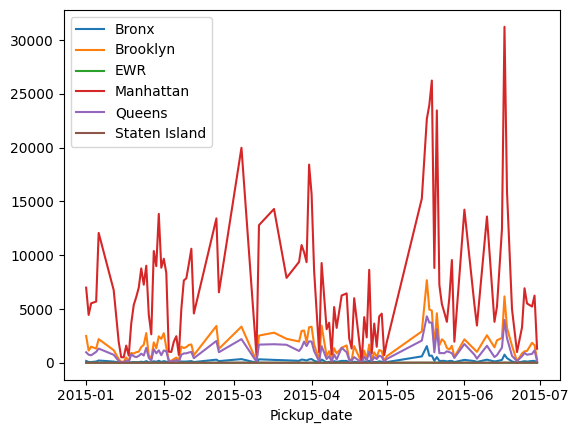

In [17]:
daily_totals.plot()

# MODELS

In [18]:
import matplotlib.pyplot as plt


In [19]:
daily_totals

,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
Pickup_date,,,,,,
2015-01-01,171,2489,0,6987,978,9
2015-01-02,72,1138,0,4451,747,7
2015-01-03,71,1500,0,5530,698,1
2015-01-05,116,1318,0,5693,1015,3
2015-01-06,210,2202,0,12076,1322,2
...,...,...,...,...,...,...
2015-06-25,149,1067,0,6929,919,3
2015-06-26,108,1104,0,5513,749,5
2015-06-28,167,1857,0,5232,829,3


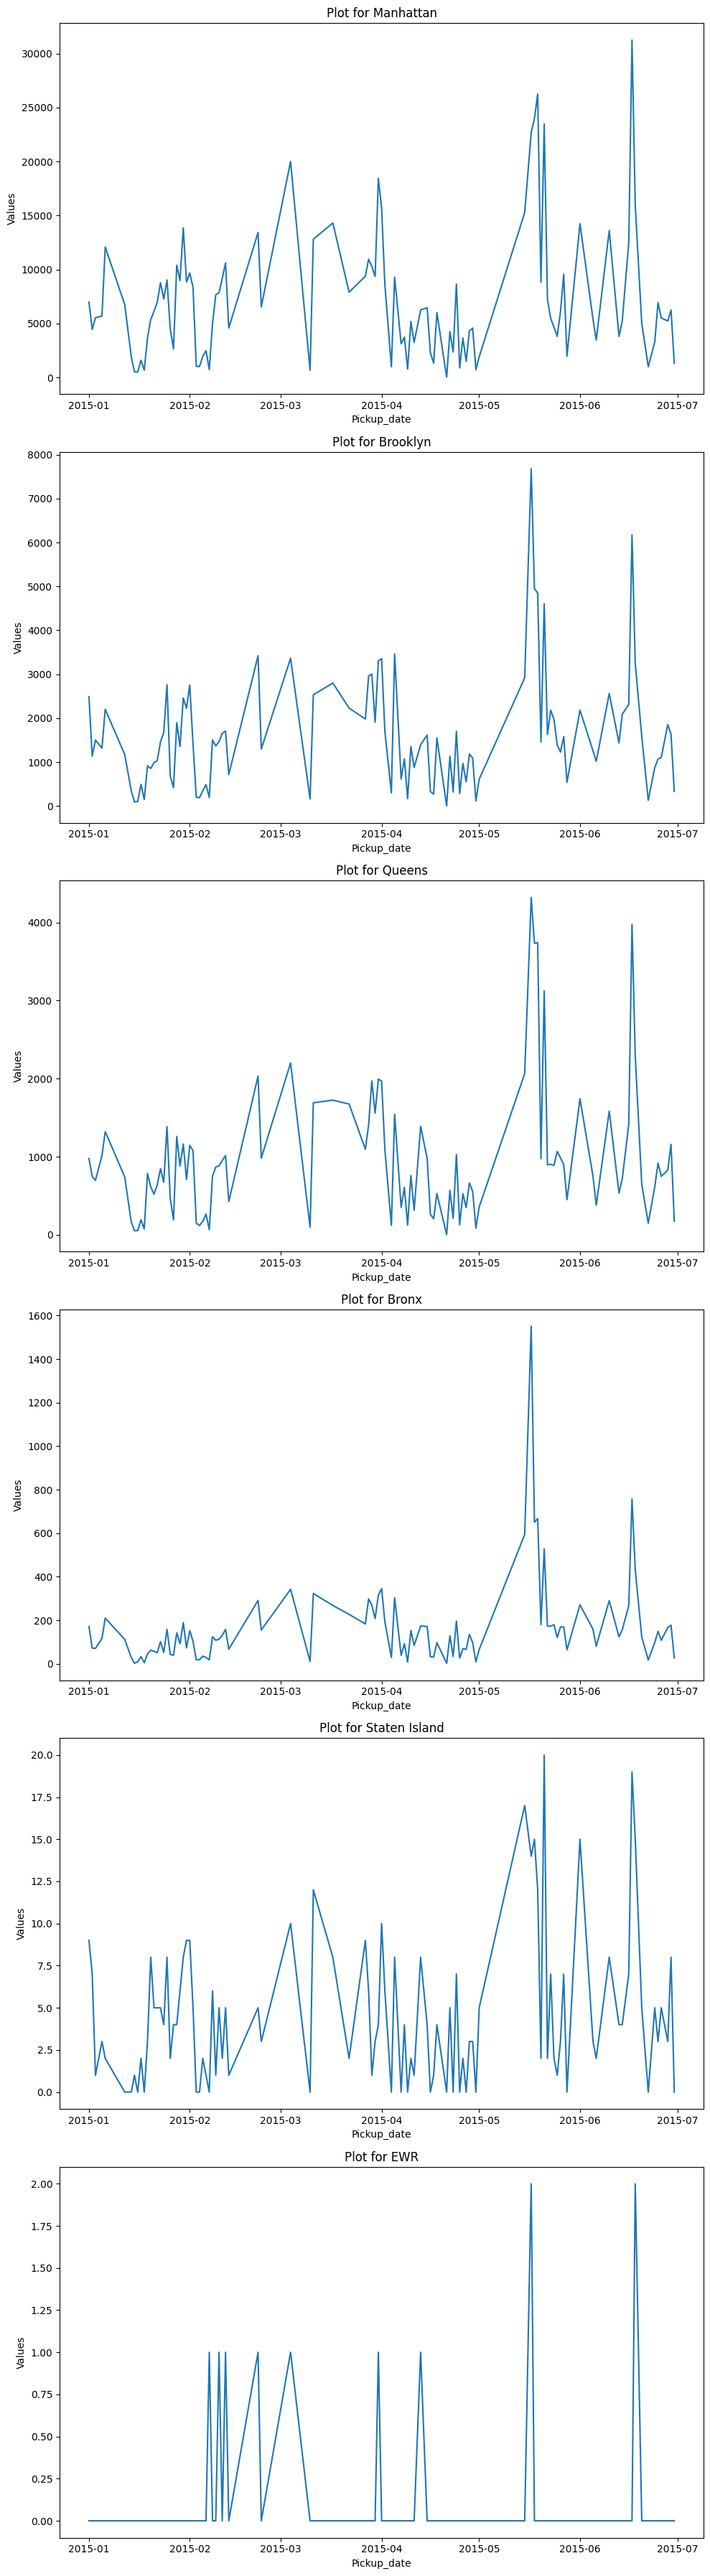

In [20]:
columns_to_plot = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'EWR']
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(10, 6 * len(columns_to_plot)))

for i, column_name in enumerate(columns_to_plot):
  daily_totals[column_name].plot(ax=axes[i], title=f'Plot for {column_name}')
  axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

## LSTMs

### 'Pickup_date' and 'Manhattan'

In [21]:
daily_totals.reset_index(inplace=True)
daily_totals

,Pickup_date,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,2015-01-01,171,2489,0,6987,978,9
1,2015-01-02,72,1138,0,4451,747,7
2,2015-01-03,71,1500,0,5530,698,1
3,2015-01-05,116,1318,0,5693,1015,3
4,2015-01-06,210,2202,0,12076,1322,2
...,...,...,...,...,...,...,...
99,2015-06-25,149,1067,0,6929,919,3
100,2015-06-26,108,1104,0,5513,749,5
101,2015-06-28,167,1857,0,5232,829,3
102,2015-06-29,177,1633,0,6248,1159,8


In [22]:

# Ensure 'Pickup_date' is a datetime column before setting it as index
daily_totals['Pickup_date'] = pd.to_datetime(daily_totals['Pickup_date'])
result_manh = daily_totals[['Pickup_date', 'Manhattan']]

# Now set 'Pickup_date' as index
result_manh.set_index('Pickup_date', inplace=True)

# Since 'Pickup_date' is now a DatetimeIndex, you can use resample
result_manh_daily = result_manh.resample('D').interpolate()


result_manh

,Manhattan
Pickup_date,
2015-01-01,6987
2015-01-02,4451
2015-01-03,5530
2015-01-05,5693
2015-01-06,12076
...,...
2015-06-25,6929
2015-06-26,5513
2015-06-28,5232


<Axes: xlabel='Pickup_date'>

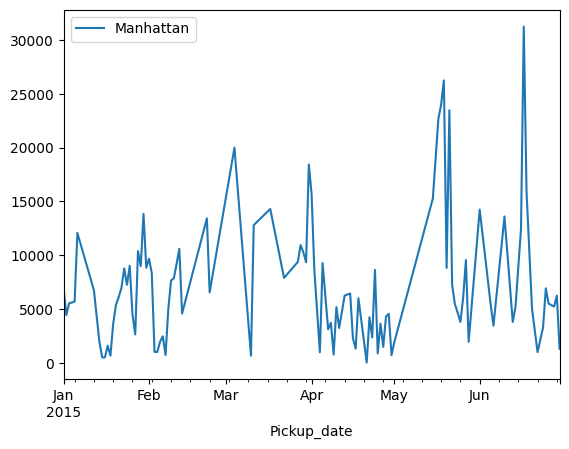

In [23]:
result_manh_daily.plot()

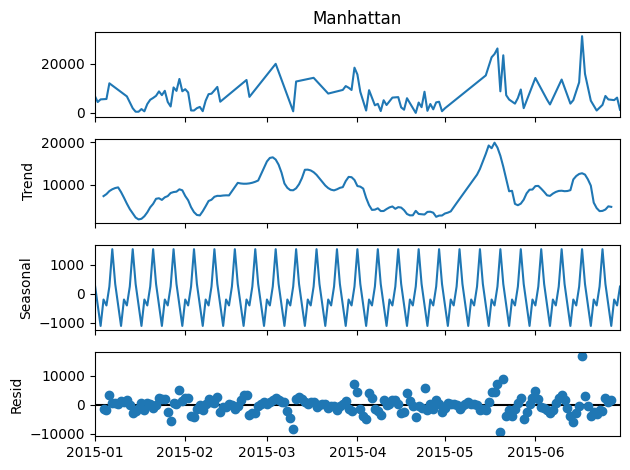

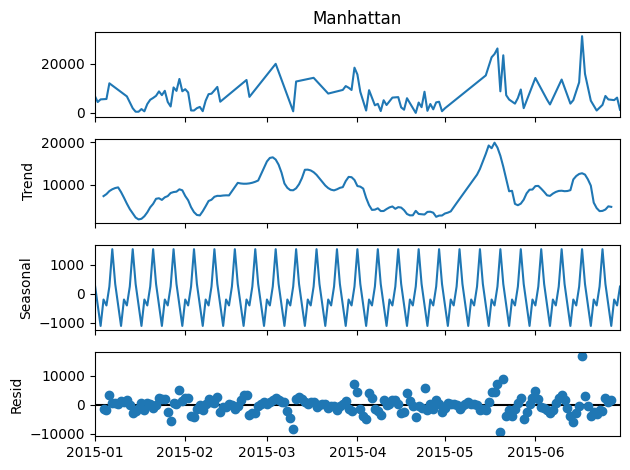

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

results_dec_manh = seasonal_decompose(result_manh_daily['Manhattan'])
results_dec_manh.plot()

In [25]:
len(result_manh_daily)

181

In [26]:
split_index = int(0.7 * len(result_manh_daily))

train_manh = result_manh_daily.iloc[:split_index]
test_manh = result_manh_daily.iloc[split_index:]

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [28]:
scaler.fit(train_manh)
scaled_train_manh=scaler.transform(train_manh)
scaled_test_manh = scaler.transform(test_manh)

In [29]:
scaled_train_manh[:10]

array([[0.3484598 ],
       [0.22143752],
       [0.27548209],
       [0.27956424],
       [0.28364638],
       [0.60335587],
       [0.55895317],
       [0.51455046],
       [0.47014776],
       [0.42574505]])

In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train_manh,scaled_train_manh,length = n_input, batch_size=1)

In [31]:
X,y = generator[0]
print(f'Given Array :\n {X.flatten()}')
print(f'Predict Y :\n {y}')

Given Array :
 [0.3484598  0.22143752 0.27548209]
Predict Y :
 [[0.27956424]]


In [32]:
X.shape

(1, 3, 1)

In [33]:
n_input = 6

generator = TimeseriesGenerator(scaled_train_manh,scaled_train_manh,length=n_input,batch_size=1)

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model_manh = Sequential()
model_manh.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model_manh.add(Dense(1))
model_manh.compile(optimizer='adam',loss='mse')

In [35]:
model_manh.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model_manh.fit(generator,epochs=100)

Epoch 1/100
120/120 [==============================] - 2s 6ms/step - loss: 0.0569
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0360
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0369
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0336
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0334
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0302
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0286
Epoch 8/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0278
Epoch 9/100
120/120 [==============================] - 1s 11ms/step - loss: 0.0263
Epoch 10/100
120/120 [==============================] - 1s 11ms/step - loss: 0.0257
Epoch 11/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0244
Epoch 12/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0238
Epoch 13/10

In [72]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.1 MB/s eta 0:00:00


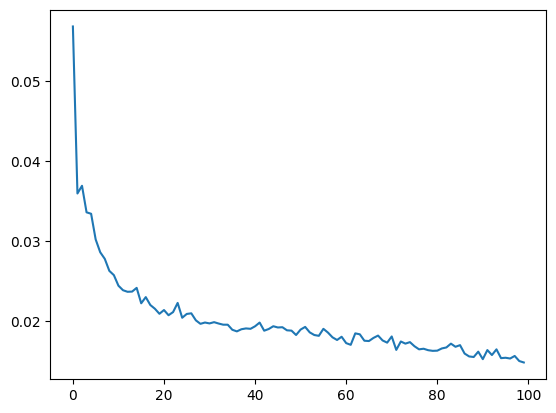

In [47]:
import matplotlib.pyplot as plt
loss_per_epoch = model_manh.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [55]:
last_train_manh_batch = scaled_train_manh[-6:]

In [56]:
last_train_manh_batch = last_train_manh_batch.reshape((1, n_input, n_features))

In [57]:
model_manh.predict(last_train_manh_batch)

1/1 [==============================] - 0s 210ms/step


array([[0.35258263]], dtype=float32)

In [58]:
scaled_test_manh[0]

array([0.38086652])

In [59]:
import numpy as np

test_prediction_manh = []

first_eval_batch = scaled_train_manh[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_manh)):

  current_pred = model_manh.predict(current_batch)[0]

  test_prediction_manh.append(current_pred)

  current_batch = np.append(current_batch[:, 1: ,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [60]:
test_prediction_manh

[array([0.35258263], dtype=float32),
 array([0.376602], dtype=float32),
 array([0.39915422], dtype=float32),
 array([0.420827], dtype=float32),
 array([0.44174728], dtype=float32),
 array([0.46196878], dtype=float32),
 array([0.48146504], dtype=float32),
 array([0.5004066], dtype=float32),
 array([0.51873535], dtype=float32),
 array([0.53642035], dtype=float32),
 array([0.55346364], dtype=float32),
 array([0.56984407], dtype=float32),
 array([0.58554983], dtype=float32),
 array([0.6004326], dtype=float32),
 array([0.6144617], dtype=float32),
 array([0.6276478], dtype=float32),
 array([0.6399964], dtype=float32),
 array([0.65152687], dtype=float32),
 array([0.6622437], dtype=float32),
 array([0.6721619], dtype=float32),
 array([0.6813081], dtype=float32),
 array([0.68975616], dtype=float32),
 array([0.69745314], dtype=float32),
 array([0.70393735], dtype=float32),
 array([0.7091562], dtype=float32),
 array([0.7131802], dtype=float32),
 array([0.7160673], dtype=float32),
 array([0.717948

In [61]:
test_manh.head()

,Manhattan
Pickup_date,
2015-05-07,7634.0
2015-05-08,8588.5
2015-05-09,9543.0
2015-05-10,10497.5
2015-05-11,11452.0


In [62]:
true_prediction = scaler.inverse_transform(test_prediction_manh)

In [63]:
test_manh1 = test_manh.copy()
test_manh1.loc[:, 'prediction'] = true_prediction

In [64]:
test_manh1.head()

,Manhattan,prediction
Pickup_date,,
2015-05-07,7634.0,7069.312278
2015-05-08,8588.5,7548.858811
2015-05-09,9543.0,7999.113923
2015-05-10,10497.5,8431.811082
2015-05-11,11452.0,8849.484405


<Axes: xlabel='Pickup_date'>

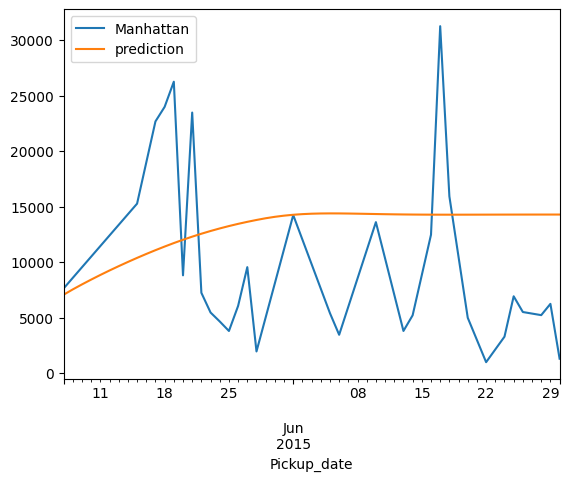

In [65]:
test_manh1.plot()

In [66]:
train_prediction1 = model_manh.predict(train_manh).flatten()
split_index = int(0.7 * len(result_manh_daily))

actuals = result_manh_daily.iloc[:split_index]['Manhattan']
train_results1 = pd.DataFrame(data={'Train Prediction': train_prediction1, 'Actuals': actuals})

train_results1

4/4 [==============================] - 0s 3ms/step


,Train Prediction,Actuals
Pickup_date,,
2015-01-01,12798.147461,6987.0
2015-01-02,8152.950684,4451.0
2015-01-03,10129.357422,5530.0
2015-01-04,10278.640625,5611.5
2015-01-05,10427.925781,5693.0
...,...,...
2015-05-02,5241.459961,2861.5
2015-05-03,6989.819824,3816.0
2015-05-04,8738.179688,4770.5


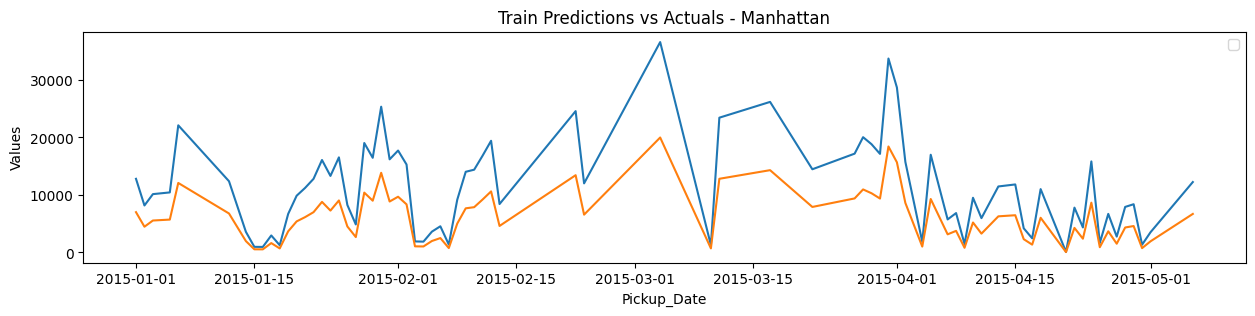

In [67]:
plt.figure(figsize=(15, 3))

plt.plot(train_results1['Train Prediction'][:1000])
plt.plot(train_results1['Actuals'][:1000])

plt.xlabel('Pickup_Date')
plt.ylabel('Values')
plt.title('Train Predictions vs Actuals - Manhattan')

plt.legend()

plt.show()

In [68]:
test_prediction1 = model_manh.predict(test_manh).flatten()
split_index = int(0.7 * len(result_manh_daily))

actuals = result_manh_daily.iloc[split_index:]['Manhattan']
test_results1 = pd.DataFrame(data={'Test Prediction': test_prediction1, 'Actuals': actuals})

test_results1

2/2 [==============================] - 0s 8ms/step


,Test Prediction,Actuals
Pickup_date,,
2015-05-07,13983.259766,7634.000000
2015-05-08,15731.618164,8588.500000
2015-05-09,17479.978516,9543.000000
2015-05-10,19228.339844,10497.500000
2015-05-11,20976.697266,11452.000000
2015-05-12,22725.056641,12406.500000
2015-05-13,24473.416016,13361.000000
2015-05-14,26221.779297,14315.500000
2015-05-15,27970.138672,15270.000000


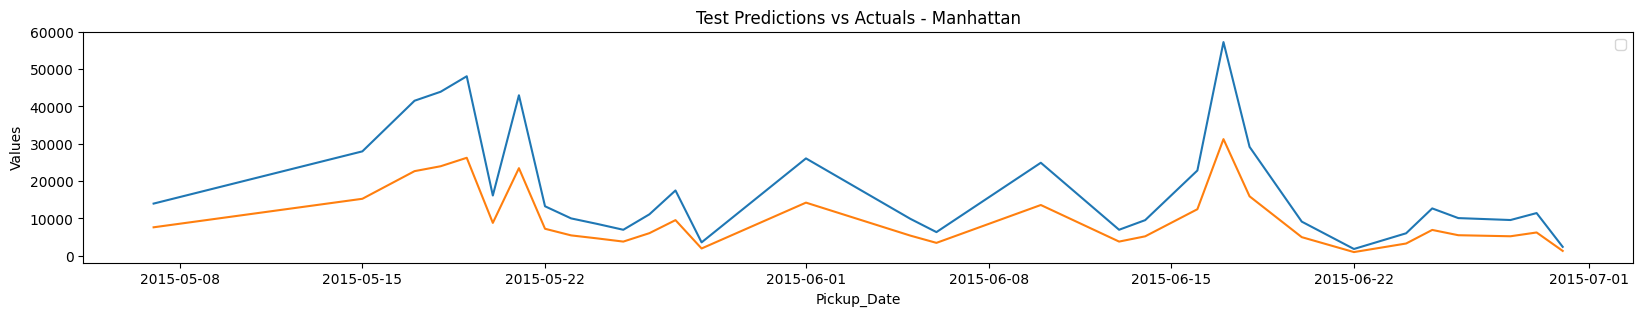

In [69]:
plt.figure(figsize=(20, 3))

plt.plot(test_results1['Test Prediction'][:1000])
plt.plot(test_results1['Actuals'][:1000])

plt.xlabel('Pickup_Date')
plt.ylabel('Values')
plt.title('Test Predictions vs Actuals - Manhattan')

plt.legend()

plt.show()

## ARIMA

In [215]:
daily_totals

,Pickup_date,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,2015-01-01,171,2489,6987,978,9
1,2015-01-02,72,1138,4451,747,7
2,2015-01-03,71,1500,5530,698,1
3,2015-01-05,116,1318,5693,1015,3
4,2015-01-06,210,2202,12076,1322,2
...,...,...,...,...,...,...
99,2015-06-25,149,1067,6929,919,3
100,2015-06-26,108,1104,5513,749,5
101,2015-06-28,167,1857,5232,829,3
102,2015-06-29,177,1633,6248,1159,8


In [ ]:
daily_totals= daily_totals.drop('EWR', axis=1)

In [95]:
# Ensure 'Pickup_date' is a datetime column before setting it as index
daily_totals['Pickup_date'] = pd.to_datetime(daily_totals['Pickup_date'])
result_manh_arima = daily_totals[['Pickup_date', 'Manhattan']]

# Now set 'Pickup_date' as index
result_manh_arima.set_index('Pickup_date', inplace=True)

# Since 'Pickup_date' is now a DatetimeIndex, you can use resample
result_manh_arima_daily = result_manh_arima.resample('D').interpolate()

result_manh_arima_daily


,Manhattan
Pickup_date,
2015-01-01,6987.0
2015-01-02,4451.0
2015-01-03,5530.0
2015-01-04,5611.5
2015-01-05,5693.0
...,...
2015-06-26,5513.0
2015-06-27,5372.5
2015-06-28,5232.0


<Axes: xlabel='Pickup_date'>

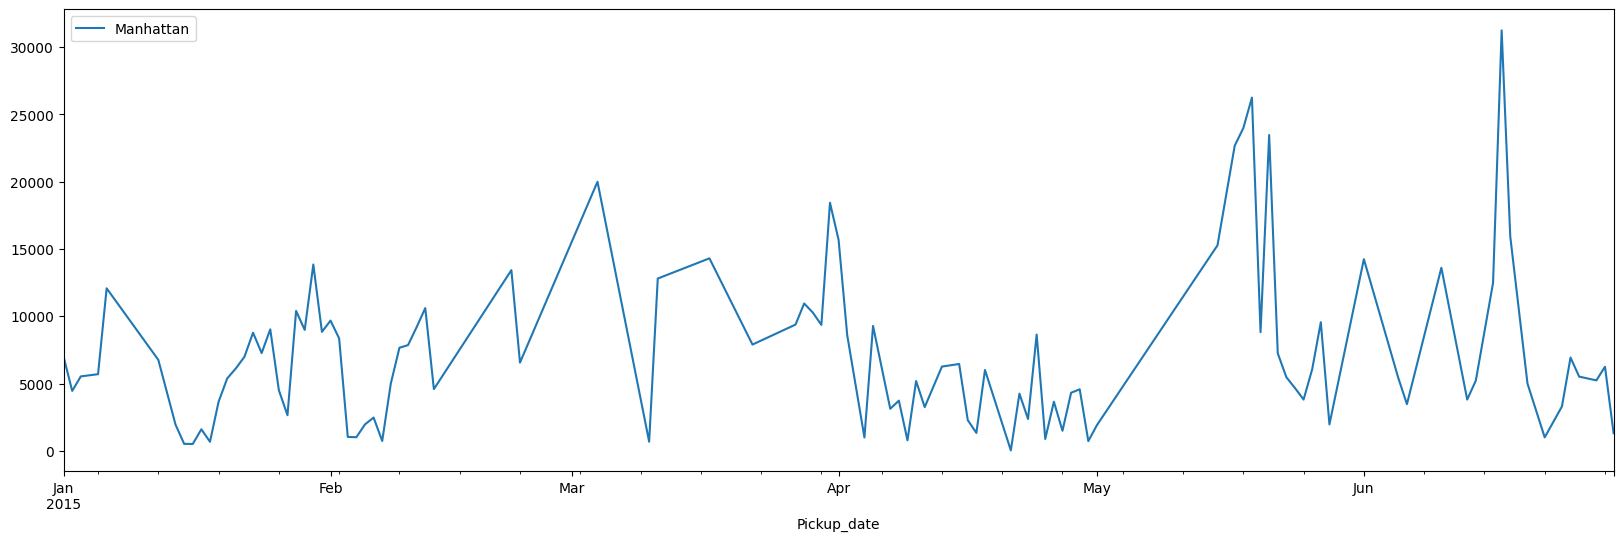

In [97]:
result_manh_arima_daily.plot(figsize=(20,6))

Check for stationary

In [117]:
from statsmodels.tsa.stattools import adfuller

def ad_test(result_manh_arima_daily):
  dftest = adfuller(result_manh_arima_daily, autolag='AIC')
  print("1. ADF :",dftest[0])
  print("2. P-value :",dftest[1])
  print("3. Num of lags :",dftest[2])
  print("4. num of observations used for ADF regression and critical value calculation :",dftest[3])
  print("5. Critical values :")
  for key,val in dftest[4].items():
    print("\t",key,": ",val)

In [118]:
ad_test(daily_totals['Manhattan'])

1. ADF : -4.432061995960538
2. P-value : 0.00026036181183812404
3. Num of lags : 1
4. num of observations used for ADF regression and critical value calculation : 102
5. Critical values :
	 1% :  -3.4961490537199116
	 5% :  -2.8903209639580556
	 10% :  -2.5821223452518263


figure out order for ARIMA model

In [105]:
!pip install pmdarima
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [119]:
stepwise_fit = auto_arima(result_manh_arima_daily['Manhattan'], trace=True,suppress_warnings=True)

stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3493.524, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3619.910, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3495.861, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3550.115, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3838.288, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3491.682, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3522.864, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3496.313, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3493.699, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3497.397, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3495.613, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3495.281, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3510.287, Time=0.09 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 2.273 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  181
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -1740.841
Date:                Tue, 02 Jan 2024   AIC                           3491.682
Time:                        10:02:37   BIC                           3507.674
Sample:                    01-01-2015   HQIC                          3498.165
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2430.0773    767.845      3.165      0.002     925.130    3935.025
ar.L1          0.6852      0.071      9.717      0.000       0.547       0.823
ma.L1         -0.0367      0.077     -0.476      0.634      -0.188       0.115
ma.L2          0.2247      0.071      3.145      0.002       0.085       0.365
sigma2      1.353e+07      0.288    4.7e+07      0.000    1.35e+07    1.35e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               241.60
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.58   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+23. Standard errors may be unstable.
"""

In [107]:
from statsmodels.tsa.arima_model import ARIMA

Split data into traiing and testing

In [120]:
print(result_manh_arima_daily.shape)

split_index = int(0.7 * len(result_manh_arima_daily))

train = result_manh_arima_daily.iloc[:split_index]
test = result_manh_arima_daily.iloc[split_index:]

print(train.shape , test.shape)

(181, 1)
(126, 1) (55, 1)


Train Model

In [192]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['Manhattan'],order = (1,0,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Manhattan   No. Observations:                  126
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1181.181
Date:                Tue, 02 Jan 2024   AIC                           2372.362
Time:                        10:49:05   BIC                           2386.543
Sample:                    01-01-2015   HQIC                          2378.123
                         - 05-06-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7449.8770   1127.350      6.608      0.000    5240.311    9659.443
ar.L1          0.7344      0.114      6.457      0.000       0.511       0.957
ma.L1          0.0031      0.163      0.019      0.985      -0.317       0.323
ma.L2          0.1107      0.113      0.980      0.327      -0.111       0.332
sigma2      8.244e+06   9.05e+05      9.110      0.000    6.47e+06       1e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                25.99
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             0.49
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Make prediction on test set

In [193]:
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start,end=end,type='levels')

#pred.index=daily_totals.index[start:end+1]
print(pred)

2015-05-07    6915.044433
2015-05-08    7112.075719
2015-05-09    7201.800352
2015-05-10    7267.692896
2015-05-11    7316.083480
2015-05-12    7351.620863
2015-05-13    7377.719031
2015-05-14    7396.885168
2015-05-15    7410.960518
2015-05-16    7421.297262
2015-05-17    7428.888426
2015-05-18    7434.463273
2015-05-19    7438.557364
2015-05-20    7441.564009
2015-05-21    7443.772047
2015-05-22    7445.393601
2015-05-23    7446.584447
2015-05-24    7447.458989
2015-05-25    7448.101240
2015-05-26    7448.572901
2015-05-27    7448.919282
2015-05-28    7449.173660
2015-05-29    7449.360471
2015-05-30    7449.497663
2015-05-31    7449.598414
2015-06-01    7449.672405
2015-06-02    7449.726743
2015-06-03    7449.766648
2015-06-04    7449.795953
2015-06-05    7449.817475
2015-06-06    7449.833280
2015-06-07    7449.844887
2015-06-08    7449.853411
2015-06-09    7449.859671
2015-06-10    7449.864269
2015-06-11    7449.867645
2015-06-12    7449.870124
2015-06-13    7449.871945
2015-06-14  

<Axes: xlabel='Pickup_date'>

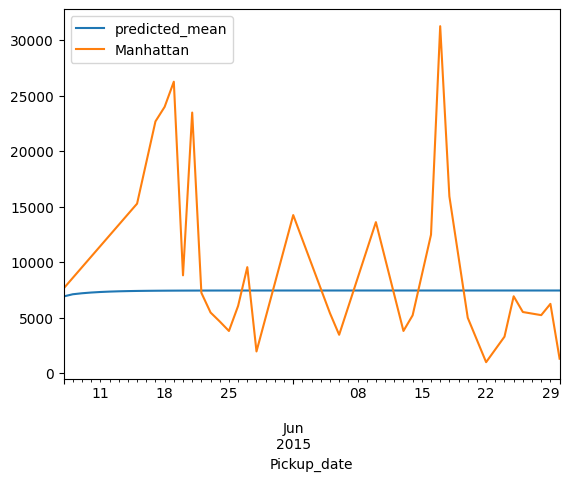

In [197]:
pred.plot(legend=True)
test['Manhattan'].plot(legend=True)

In [195]:
test['Manhattan'].mean()

9682.018181818183

In [196]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_extended = np.concatenate([pred, np.zeros(len(result_manh_arima_daily['Manhattan']) - len(pred))])

rmse = sqrt(mean_squared_error(pred_extended, result_manh_arima_daily['Manhattan']))

print(rmse)

8955.491187705715


In [132]:
model2 = ARIMA(result_manh_arima_daily['Manhattan'], order=(1,0,2))
model2=model2.fit()
result_manh_arima_daily.tail()

,Manhattan
Pickup_date,
2015-06-26,5513.0
2015-06-27,5372.5
2015-06-28,5232.0
2015-06-29,6248.0
2015-06-30,1309.0


In [142]:
# Adjust the date range to match the number of predictions
index_future_data = pd.date_range(start='2015-06-30', end='2015-07-27')  # 28 days

# Assuming pred is your predictions with 28 rows
pred = model2.predict(start=len(result_manh_arima_daily), end=len(result_manh_arima_daily) + 27, type='levels').rename('ARIMA Prediction')
pred = pred.to_frame()

# Set the adjusted index
pred.set_index(index_future_data, inplace=True)

print(pred)



            ARIMA Prediction
2015-06-30       3894.693115
2015-07-01       4066.291953
2015-07-02       5611.531763
2015-07-03       6568.921158
2015-07-04       7162.094106
2015-07-05       7529.608252
2015-07-06       7757.310220
2015-07-07       7898.388290
2015-07-08       7985.796501
2015-07-09       8039.952298
2015-07-10       8073.505787
2015-07-11       8094.294634
2015-07-12       8107.174850
2015-07-13       8115.155088
2015-07-14       8120.099431
2015-07-15       8123.162814
2015-07-16       8125.060804
2015-07-17       8126.236748
2015-07-18       8126.965332
2015-07-19       8127.416743
2015-07-20       8127.696425
2015-07-21       8127.869709
2015-07-22       8127.977071
2015-07-23       8128.043590
2015-07-24       8128.084803
2015-07-25       8128.110337
2015-07-26       8128.126158
2015-07-27       8128.135960


<Axes: >

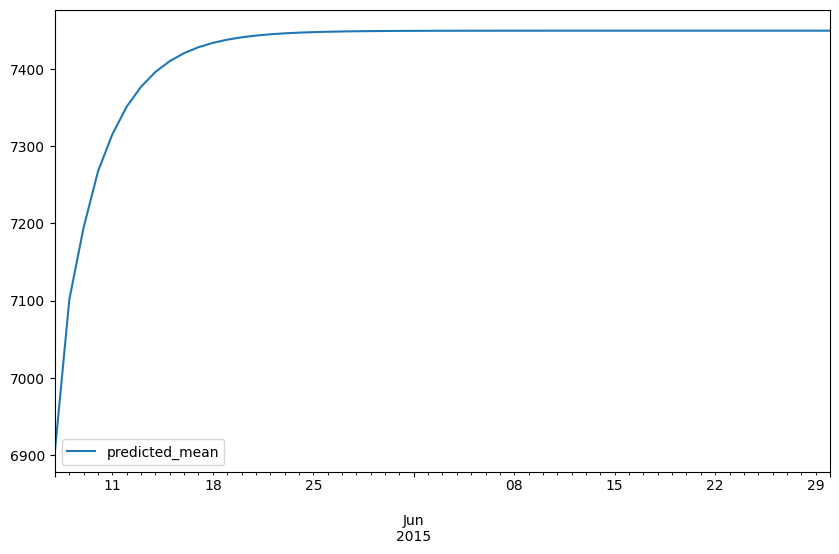

In [157]:
pred.plot(figsize=(10,6),legend=True)

### 2nd

In [145]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

auto_model = auto_arima(result_manh_arima_daily['Manhattan'], seasonal=False, m=1, trace=True,
                        error_action='ignore', suppress_warnings=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3511.202, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3838.288, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3514.843, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3737.296, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3510.287, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3622.969, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3509.718, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3509.531, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3508.502, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3509.501, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3511.406, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3495.228, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3495.861, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3492.384, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept

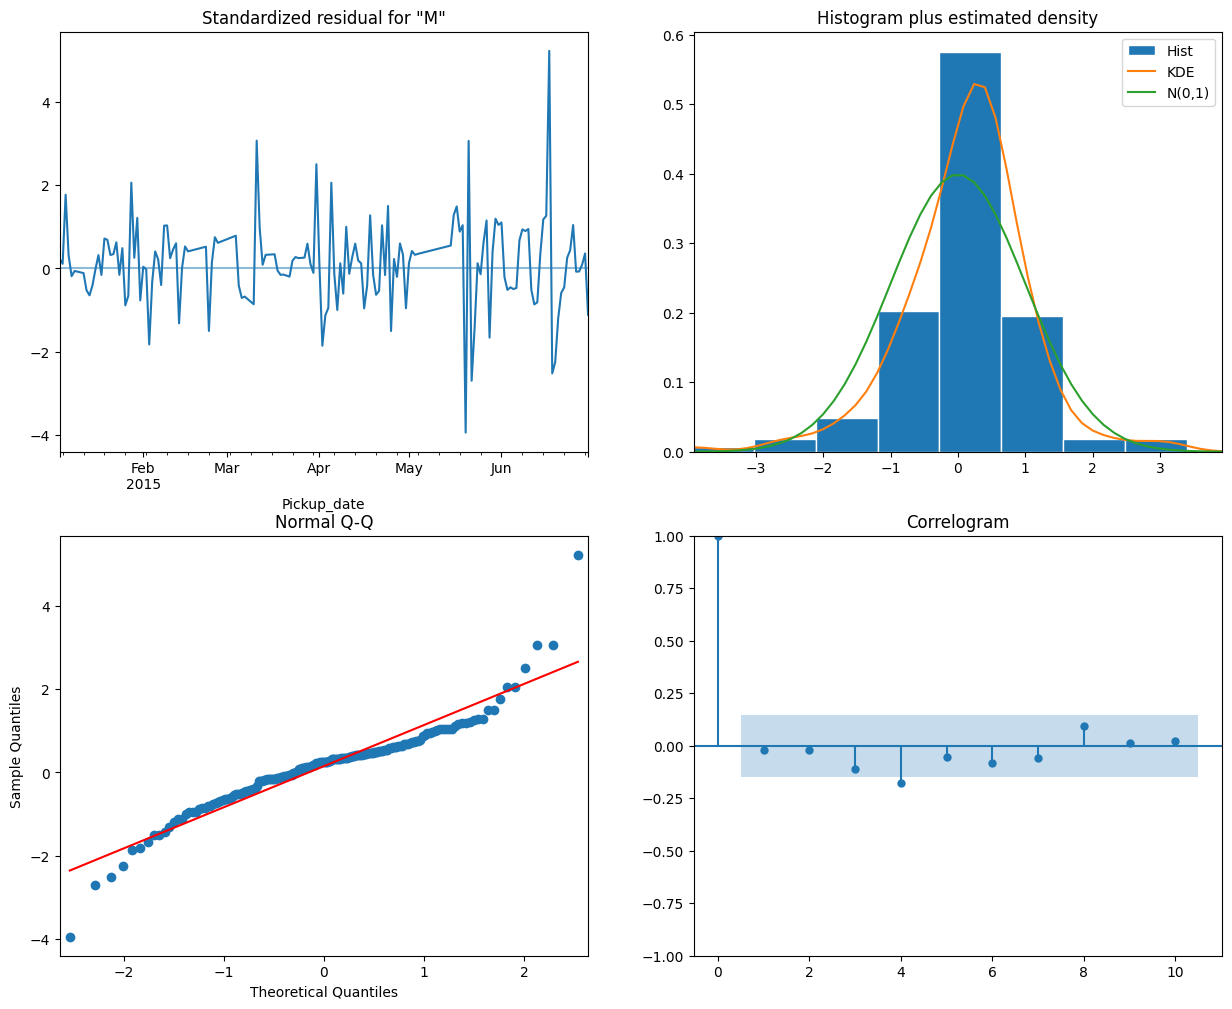

In [147]:
model = SARIMAX(result_manh_arima_daily['Manhattan'], order=auto_model.order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

results.plot_diagnostics(figsize=(15, 12))
plt.show()

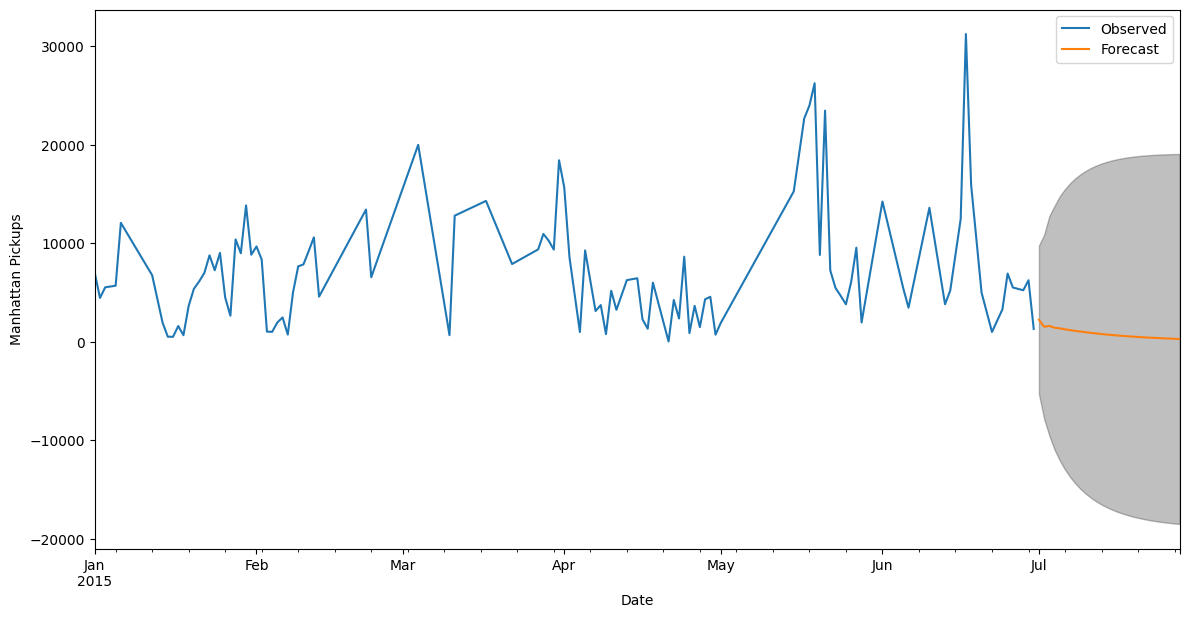

In [149]:
pred_uc = results.get_forecast(steps=28)

pred_ci = pred_uc.conf_int()

ax = result_manh_arima_daily['Manhattan'].plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')

ax.set_ylabel('Manhattan Pickups')

plt.legend()
plt.show()

### 3rd

In [155]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from pmdarima import auto_arima

df = daily_totals.copy()

train_data, test_data = train_test_split(df['Manhattan'], test_size=0.2, shuffle=False)

train_data_log = np.log(train_data + 1)

auto_model = auto_arima(train_data_log, seasonal=True, m=7, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=True)

model = SARIMAX(train_data_log,
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=251.997, Time=1.32 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=258.663, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=252.560, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=254.500, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=593.036, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=251.071, Time=1.26 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=250.670, Time=0.28 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=250.753, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=249.163, Time=0.32 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=251.702, Time=0.74 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=249.473, Time=0.58 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=252.675, Time=0.95 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=251.036, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=248.298, 

Test RMSE: 6940.565


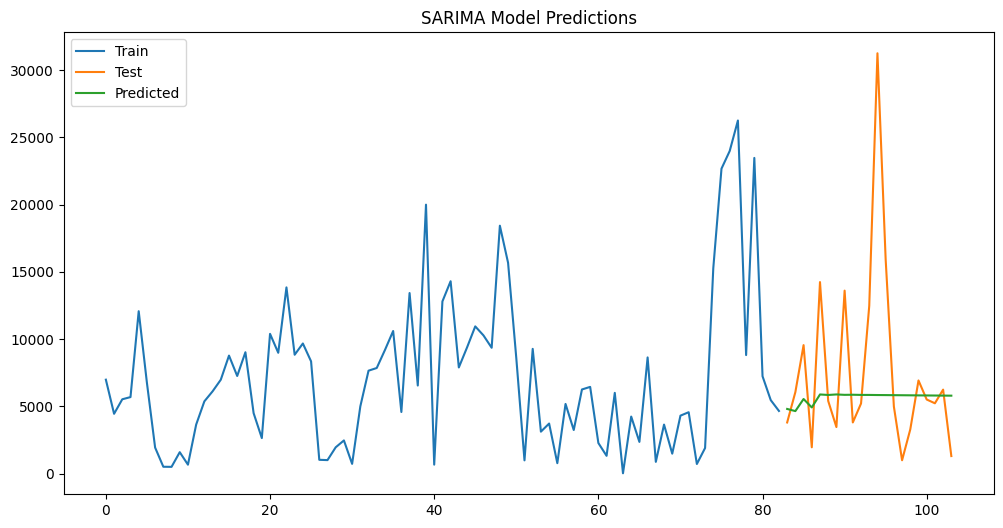

In [156]:
predictions = results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
predictions = np.exp(predictions) - 1

rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(predictions.index, predictions, label='Predicted')
plt.legend(loc='best')
plt.title('SARIMA Model Predictions')
plt.show()

## PROPHET

In [198]:
daily_totals

,Pickup_date,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,2015-01-01,171,2489,0,6987,978,9
1,2015-01-02,72,1138,0,4451,747,7
2,2015-01-03,71,1500,0,5530,698,1
3,2015-01-05,116,1318,0,5693,1015,3
4,2015-01-06,210,2202,0,12076,1322,2
...,...,...,...,...,...,...,...
99,2015-06-25,149,1067,0,6929,919,3
100,2015-06-26,108,1104,0,5513,749,5
101,2015-06-28,167,1857,0,5232,829,3
102,2015-06-29,177,1633,0,6248,1159,8


In [212]:
daily_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Pickup_date    104 non-null    datetime64[ns]
 1   Bronx          104 non-null    int64         
 2   Brooklyn       104 non-null    int64         
 3   EWR            104 non-null    int64         
 4   Manhattan      104 non-null    int64         
 5   Queens         104 non-null    int64         
 6   Staten Island  104 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 5.8 KB


In [199]:
# Ensure 'Pickup_date' is a datetime column before setting it as index
daily_totals['Pickup_date'] = pd.to_datetime(daily_totals['Pickup_date'])
result_manh_prophet = daily_totals[['Pickup_date', 'Manhattan']]

# Now set 'Pickup_date' as index
result_manh_prophet.set_index('Pickup_date', inplace=True)

# Since 'Pickup_date' is now a DatetimeIndex, you can use resample
result_manh_prophet_daily = result_manh_arima.resample('D').interpolate()

result_manh_prophet_daily

,Manhattan
Pickup_date,
2015-01-01,6987.0
2015-01-02,4451.0
2015-01-03,5530.0
2015-01-04,5611.5
2015-01-05,5693.0
...,...
2015-06-26,5513.0
2015-06-27,5372.5
2015-06-28,5232.0


In [201]:
!pip install prophet

In [207]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


In [208]:
!pip install pystan --upgrade


  Using cached pystan-3.8.0-py3-none-any.whl (13 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.8 MB)
  Using cached pysimdjson-5.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached marshmallow-3.20.1-py3-none-any.whl (49 kB)
  Using cached webargs-8.3.0-py3-none-any.whl (31 kB)


In [209]:
!pip install prophet


In [211]:
from prophet import Prophet


In [217]:
daily_totals_num = daily_totals.copy()

#daily_totals_num=daily_totals_num.drop('EWR', axis=1)

In [218]:
daily_totals_num

,Pickup_date,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,2015-01-01,171,2489,6987,978,9
1,2015-01-02,72,1138,4451,747,7
2,2015-01-03,71,1500,5530,698,1
3,2015-01-05,116,1318,5693,1015,3
4,2015-01-06,210,2202,12076,1322,2
...,...,...,...,...,...,...
99,2015-06-25,149,1067,6929,919,3
100,2015-06-26,108,1104,5513,749,5
101,2015-06-28,167,1857,5232,829,3
102,2015-06-29,177,1633,6248,1159,8


In [220]:
daily_totals_num = daily_totals_num[["Pickup_date","Manhattan"]]
daily_totals_num.head()

,Pickup_date,Manhattan
0,2015-01-01,6987
1,2015-01-02,4451
2,2015-01-03,5530
3,2015-01-05,5693
4,2015-01-06,12076


change column names

In [221]:
daily_totals_num.columns = ['ds','y']

In [222]:
daily_totals_num['ds']=pd.to_datetime(daily_totals_num['ds'])
daily_totals_num.tail()


,ds,y
99,2015-06-25,6929
100,2015-06-26,5513
101,2015-06-28,5232
102,2015-06-29,6248
103,2015-06-30,1309


<Axes: xlabel='ds'>

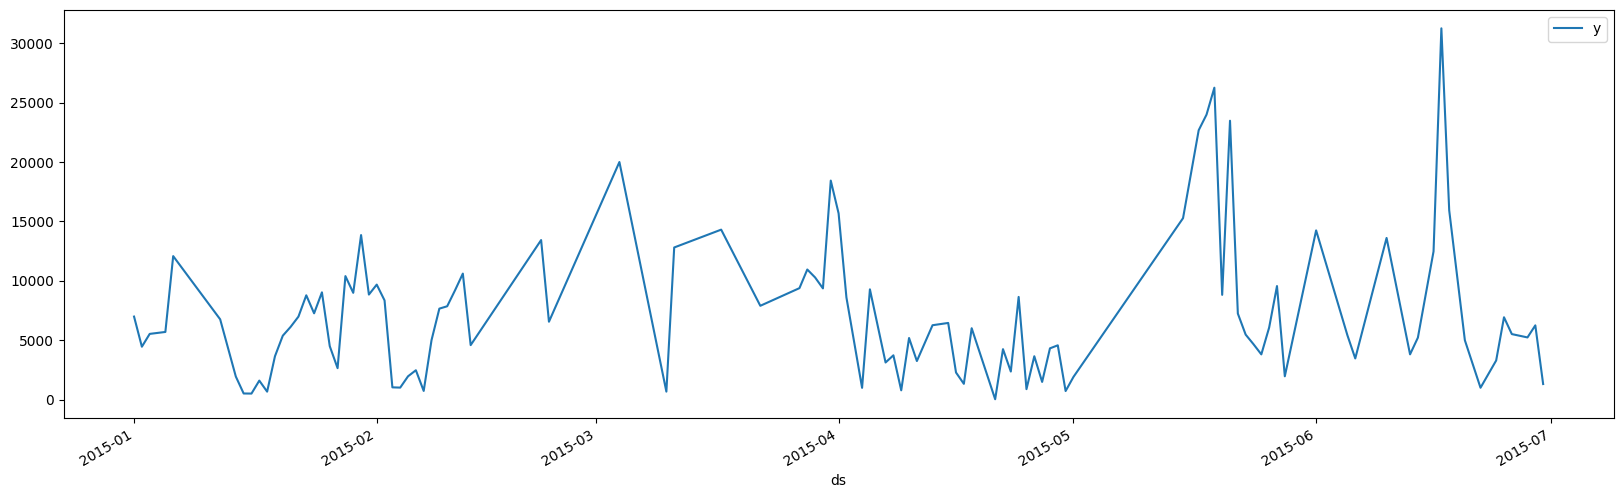

In [224]:
daily_totals_num.plot(x='ds',y='y',figsize=(20,6))

split data

In [225]:
print(daily_totals_num.shape)

split_index = int(0.7 * len(daily_totals_num))

train = daily_totals_num.iloc[:split_index]
test = daily_totals_num.iloc[split_index:]

print(train.shape , test.shape)

(104, 2)
(72, 2) (32, 2)


In [226]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp657s4qp4/h1c7le1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp657s4qp4/s2l47_s8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31464', 'data', 'file=/tmp/tmp657s4qp4/h1c7le1a.json', 'init=/tmp/tmp657s4qp4/s2l47_s8.json', 'output', 'file=/tmp/tmp657s4qp4/prophet_model4x688rb7/prophet_model-20240102112955.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:29:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [227]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
432,2016-04-24,3707.363156,-426.379012,10527.176215,3707.241178,3707.477631,1451.834131,1451.834131,1451.834131,1451.834131,1451.834131,1451.834131,0.0,0.0,0.0,5159.197287
433,2016-04-25,3701.386562,-1703.680629,8708.926268,3701.264224,3701.501496,-255.276581,-255.276581,-255.276581,-255.276581,-255.276581,-255.276581,0.0,0.0,0.0,3446.109981
434,2016-04-26,3695.409968,-1489.737808,9129.663897,3695.287270,3695.525346,149.467580,149.467580,149.467580,149.467580,149.467580,149.467580,0.0,0.0,0.0,3844.877548
435,2016-04-27,3689.433374,24.499522,10771.876257,3689.310317,3689.549193,1843.842691,1843.842691,1843.842691,1843.842691,1843.842691,1843.842691,0.0,0.0,0.0,5533.276065
436,2016-04-28,3683.456780,-3153.726800,7839.654773,3683.333370,3683.573122,-1247.291099,-1247.291099,-1247.291099,-1247.291099,-1247.291099,-1247.291099,0.0,0.0,0.0,2436.165681


In [228]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
432,2016-04-24,5159.197287,-426.379012,10527.176215
433,2016-04-25,3446.109981,-1703.680629,8708.926268
434,2016-04-26,3844.877548,-1489.737808,9129.663897
435,2016-04-27,5533.276065,24.499522,10771.876257
436,2016-04-28,2436.165681,-3153.726800,7839.654773


In [229]:
test.tail()

,ds,y
99,2015-06-25,6929
100,2015-06-26,5513
101,2015-06-28,5232
102,2015-06-29,6248
103,2015-06-30,1309


visualization

In [231]:
plot_plotly(m,forecast)

In [233]:
plot_components_plotly(m,forecast)

In [234]:
predictions = forecast.iloc[split_index:]['yhat']

In [238]:
from sklearn.metrics import mean_squared_error
import numpy as np

print("RMSE:", rmse)
print("MEAN:", test['y'].mean())

RMSE: 8955.491187705715
MEAN: 9429.84375
